# Setup

## Import Library

# Cek GPU

In [1]:
import os
import asyncio
import importlib
import time
import shutil
import random
import copy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
import torch.optim as optim
from torchvision.models import mobilenet_v2, MobileNet_V3_Small_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import swin_t, Swin_T_Weights
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
torch.cuda.empty_cache()

In [3]:
print(torch.cuda.is_available())

True


# EDA

## Distribusi datasets

Distribusi dataset: {'print': 5100, 'real': 5100, 'replay': 5100}


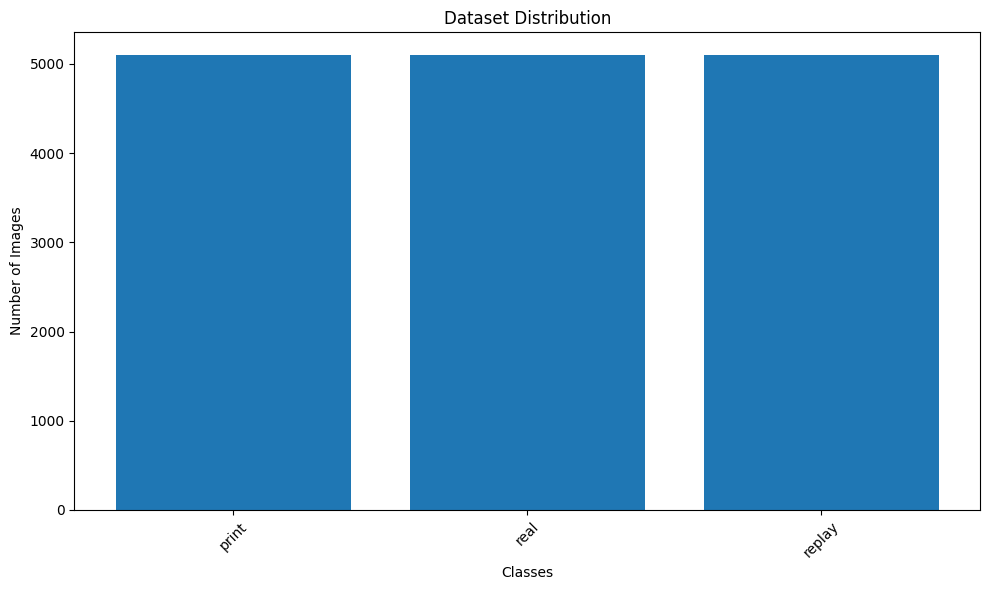

In [4]:
def count_images_in_classes(folder_path):
    """Menghitung jumlah gambar dalam setiap kelas di folder."""
    class_counts = {}
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path): 
            class_counts[class_folder] = len([
                f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))
            ])
    return class_counts

def plot_distribution(class_counts, title):
    """Menampilkan distribusi dataset menggunakan grafik batang."""
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Path ke folder dataset
home_path = "/home/machi/code/python/TelU-TugasAkhir-LivenessDetection"
dataset_path = f"{home_path}/latest_datasets"

# Hitung distribusi kelas 
datasets_class_counts = count_images_in_classes(dataset_path)
print(f"Distribusi dataset: {datasets_class_counts}")
plot_distribution(datasets_class_counts, "Dataset Distribution")

## Preview datasets

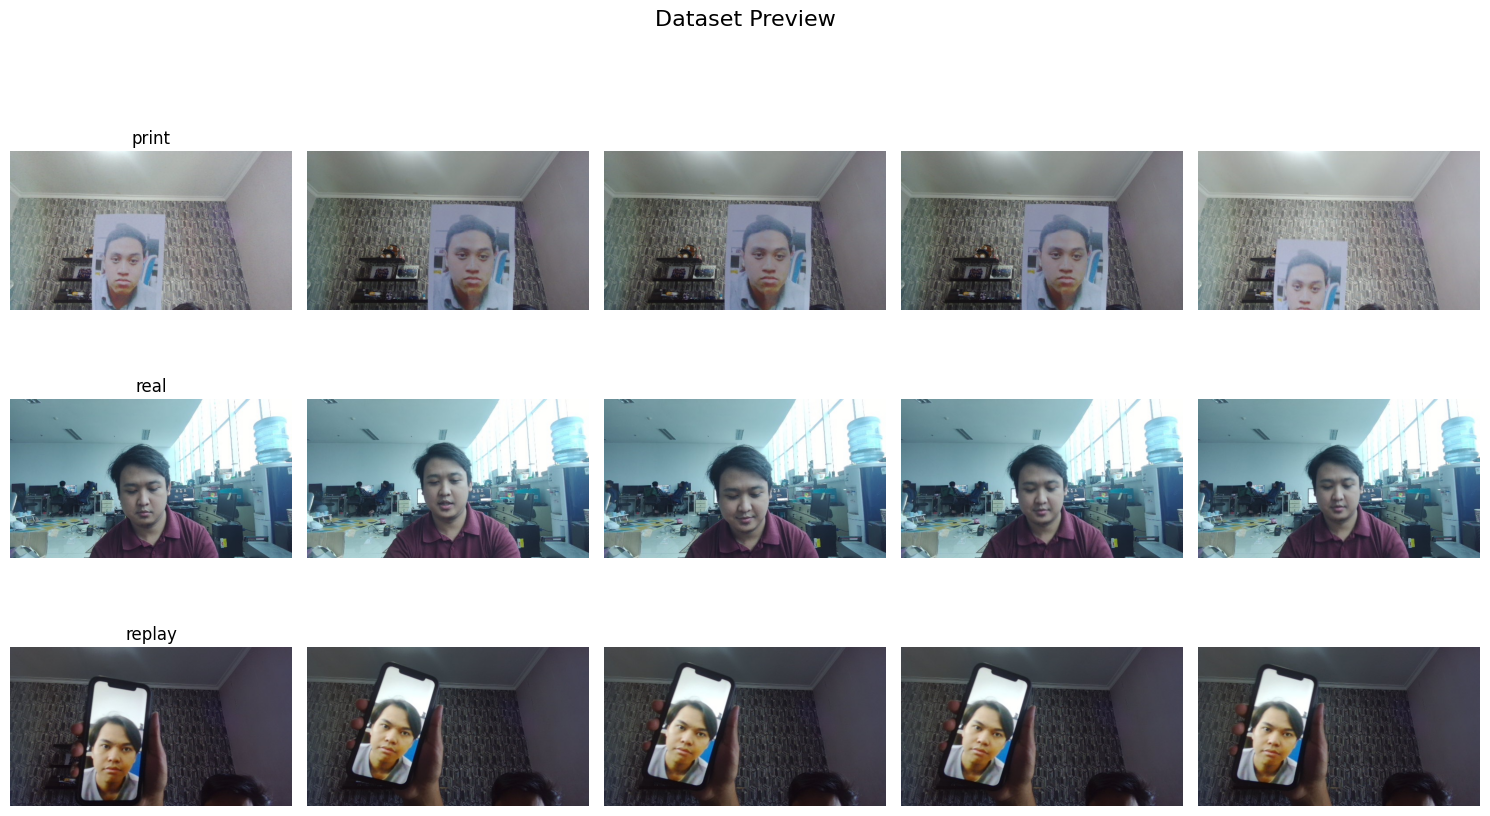

In [5]:
def preview_images(folder_path, title, samples_per_class=5):
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    num_classes = len(classes)

    # Setup grid untuk menampilkan gambar
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))
    fig.suptitle(title, fontsize=16)

    for i, cls in enumerate(classes):
        class_path = os.path.join(folder_path, cls)
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        name_video = "video1_"
        sample_images = [img for img in images if name_video in img][:samples_per_class]  # Filter gambar
        
        for j in range(samples_per_class):
            ax = axes[i, j] if num_classes > 1 else axes[j]  # Jika hanya 1 kelas, axes menjadi 1D
            ax.axis('off')

            if j < len(sample_images):  # Jika ada gambar yang cukup
                img_path = os.path.join(class_path, sample_images[j])
                img = Image.open(img_path)
                ax.imshow(img)
                ax.set_title(cls if j == 0 else "")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


# Preview gambar di folder
preview_images(dataset_path, "Dataset Preview", samples_per_class=5)

# EfficientNetV2

In [6]:
# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Membuat dictionary untuk setiap model EfficientNetV2 dan menghitung jumlah parameternya
list_models = {
    "EfficientNetV2_Small": models.efficientnet_v2_s(weights=None),
    "EfficientNetV2_Medium": models.efficientnet_v2_m(weights=None),
    "EfficientNetV2_Large": models.efficientnet_v2_l(weights=None),
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

,Model,Parameter Count
0,EfficientNetV2_Small,21.458.488
1,EfficientNetV2_Medium,54.139.356
2,EfficientNetV2_Large,118.515.272


# Swin Transformer

In [7]:
# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Membuat dictionary untuk setiap model Swin Transformer dan menghitung jumlah parameternya
list_models = {
    "Swin-Tiny": models.swin_t(weights="IMAGENET1K_V1"),
    "Swin-Small": models.swin_s(weights="IMAGENET1K_V1"),
    "Swin-Base": models.swin_b(weights="IMAGENET1K_V1")
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

,Model,Parameter Count
0,Swin-Tiny,28.288.354
1,Swin-Small,49.606.258
2,Swin-Base,87.768.224


# Training

## Variable Global

In [8]:
save_model_path = f"{home_path}/results/best_model/"
result_csv_path = f"{home_path}/results/csv/"
image_path = f"{home_path}/results/images/"
class_names = ['real', 'replay', 'print'] 

In [9]:
# Random seed
random.seed(42)

## Hyperparameter Settings

## Split Dataset

In [10]:
base_path = dataset_path
class_folders = ['real', 'replay', 'print']
file_paths = []
labels = []
video_ids = []

# --- Step 1: Scan folders and prepare the data ---
print("Scanning data folders...")
for folder in class_folders:
    class_path = os.path.join(base_path, folder)
    if not os.path.isdir(class_path):
        print(f"Warning: Directory not found at {class_path}. Skipping.")
        continue
    for filename in os.listdir(class_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_file_path = os.path.join(class_path, filename)
            file_paths.append(full_file_path)
            labels.append(folder)
            # Membuat ID unik untuk setiap video
            base_video_id = os.path.splitext(os.path.basename(full_file_path))[0].split('_')[0]
            unique_video_id = f"{folder}_{base_video_id}"
            video_ids.append(unique_video_id)

df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels,
    'video_id': video_ids
})
df['label_encoded'], unique_labels = pd.factorize(df['label'])

print(f"Found {len(df)} total frames from {df['video_id'].nunique()} unique videos.")
class_names = unique_labels.tolist()
print(f"Discovered class names in order: {class_names}")
print("\n" + "="*60 + "\n")


# --- STEP 2 & 3: Melakukan Pembagian Data Biasa (Non-Group) ---

print("### Performing Regular Stratified Split (Ignoring Video Groups)... ###")

# Pembagian pertama: Pisahkan Test set (20%) dari sisa data (Train+Val, 80%)
# `stratify=df['label_encoded']` digunakan untuk menjaga keseimbangan kelas.
train_val_df, test_df = train_test_split(
    df,
    test_size=0.20,
    random_state=42,
    stratify=df['label_encoded']
)

# Pembagian kedua: Pisahkan Validation set dari Train+Val set.
# Kita mengambil 25% dari train_val_df untuk mendapatkan 20% dari total data asli.
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.25,
    random_state=42,
    stratify=train_val_df['label_encoded']
)

print("Regular splitting complete.")
print("\n--- Final Set Sizes (based on frames) ---")
print(f"Training set:   {len(train_df)} frames")
print(f"Validation set: {len(val_df)} frames")
print(f"Test set:       {len(test_df)} frames")
print("\n" + "="*60 + "\n")


Scanning data folders...
Found 15300 total frames from 36 unique videos.
Discovered class names in order: ['real', 'replay', 'print']


### Performing Regular Stratified Split (Ignoring Video Groups)... ###
Regular splitting complete.

--- Final Set Sizes (based on frames) ---
Training set:   9180 frames
Validation set: 3060 frames
Test set:       3060 frames




## Data Augmentation

In [11]:
def add_random_noise_pytorch(img_tensor):
    """Add Gaussian noise to a PyTorch image tensor."""
    if torch.rand(1).item() > 0.6: # Apply noise 30% of the time
        VARIABILITY = 50
        # Create noise with the same device and shape as the input tensor
        deviation = VARIABILITY * random.random()
        noise = torch.randn(img_tensor.size(), device=img_tensor.device) * deviation
        
        # Add noise and clamp to the valid range
        # Note: We work with float tensors in the [0, 255] range here before scaling
        img_tensor = img_tensor + noise
        img_tensor = torch.clamp(img_tensor, 0, 255)
    
    return img_tensor


In [12]:
# Define Transforms
output_size = (224, 224)

    # Define the cropping factor (e.g., 0.8 means cropping to 80% of original size)
crop_factor = 0.5 
crop_size = (int(output_size[0] * crop_factor), int(output_size[1] * crop_factor))

transform_train = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(20),
    v2.RandomZoomOut(fill=0.0, side_range=(1.0, 2.0), p=0.),
    v2.RandomApply([
        v2.RandomResizedCrop(size=output_size, scale=(0.8, 1.0))
    ], p=0.5),
    # v2.GaussianBlur(kernel_size=3, sigma=(0.1, 0.3)),
    # v2.GaussianNoise(mean=0, sigma=0.02),
    v2.GaussianNoise(mean=0.1, sigma=0.1),
    v2.GaussianBlur(kernel_size=(3, 7), sigma=(1, 4)),
    v2.ColorJitter(brightness=(0.3, 1.4), contrast=(0.8, 1), hue=(0, 0.2)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_ori_train = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.GaussianNoise(mean=0, sigma=0.02),
    v2.GaussianBlur(kernel_size=1, sigma=0.3),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val_test = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [13]:
# Create a Custom Dataset Class
class VideoFrameDataset(Dataset):
    def __init__(self, dataframe, transform=None, class_names=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing file paths and labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.transform = transform
        self.classes = class_names

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Fetches the sample at the given index.
        1. Gets the file path and label from the DataFrame.
        2. Loads the image from the file path.
        3. Applies the transform (if any).
        4. Returns the transformed image and its label.
        """
        # Get the row from the dataframe
        row = self.dataframe.iloc[idx]
        
        # Get the file path and the encoded label
        image_path = row['file_path']
        label = row['label_encoded']
        
        # Load the image using PIL (Pillow)
        # .convert("RGB") is important to handle grayscale images
        image = Image.open(image_path).convert("RGB")
        
        # Apply the transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

# We now use our custom class instead of ImageFolder
# Create instances from custom Dataset
original_dataset = VideoFrameDataset(dataframe=train_df, transform=transform_ori_train, class_names=class_names)
augmented_dataset = VideoFrameDataset(dataframe=train_df, transform=transform_train, class_names=class_names)
ori_dataset = VideoFrameDataset(dataframe=train_df, transform=transform_val_test, class_names=class_names)
train_dataset = ConcatDataset([original_dataset, augmented_dataset])
val_dataset = VideoFrameDataset(dataframe=val_df, transform=transform_val_test, class_names=class_names)
test_dataset = VideoFrameDataset(dataframe=test_df, transform=transform_val_test, class_names=class_names)


Sample images from original dataset:


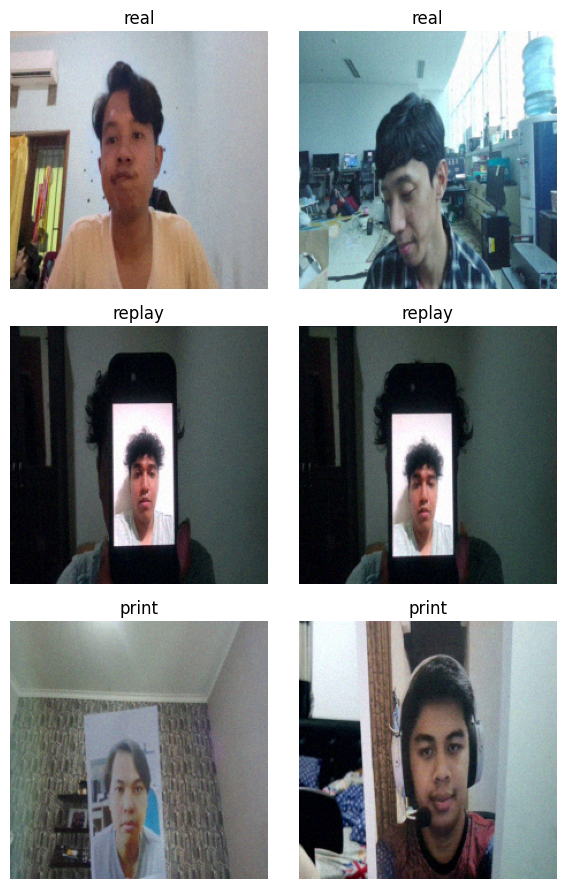

Sample images from augmented dataset:


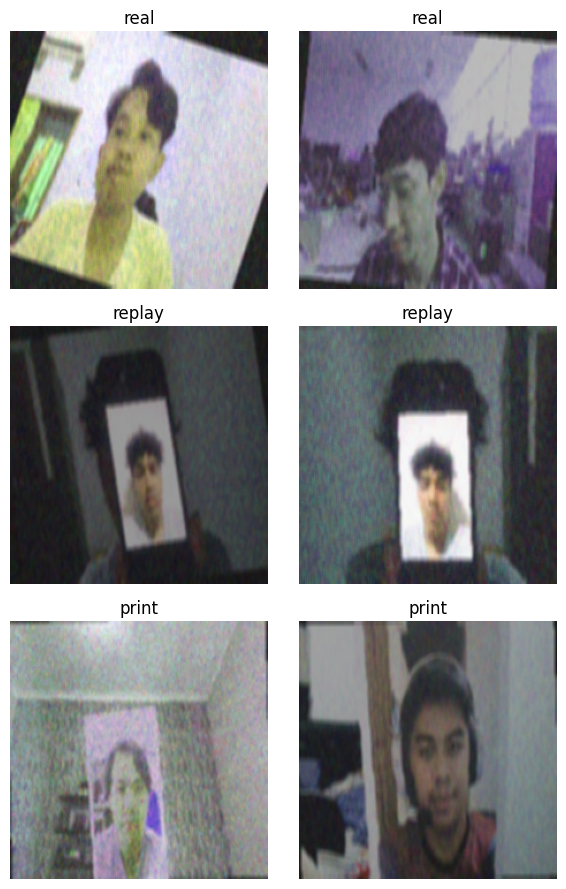

In [14]:
# Show sample images of ori_dataset and augmented_dataset on each class

def show_sample_images(dataset, num_samples=2):

    """Display a few sample images from the dataset each class."""

    class_samples = {cls: [] for cls in dataset.classes}
    for img, label in dataset:
        class_name = dataset.classes[label]
        if len(class_samples[class_name]) < num_samples:
            class_samples[class_name].append(img)
            if all(len(samples) >= num_samples for samples in class_samples.values()):
                break
    fig, axes = plt.subplots(len(dataset.classes), num_samples, figsize=(num_samples * 3, len(dataset.classes) * 3))
    for i, (class_name, samples) in enumerate(class_samples.items()):
        for j, img in enumerate(samples):
            ax = axes[i, j] if len(dataset.classes) > 1 else axes[j]
            image = img.permute(1, 2, 0).numpy()
            image = (image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) # Denormalize
            image = np.clip(image, 0, 1)
            ax.imshow(image)
            ax.set_title(class_name)
            ax.axis('off')
    plt.tight_layout()
    plt.show()




# Show sample images from original dataset
print("Sample images from original dataset:")
show_sample_images(original_dataset, num_samples=2)
# Show sample images from augmented dataset
print("Sample images from augmented dataset:")
show_sample_images(augmented_dataset, num_samples=2) 

In [15]:
print(f"Train dataset size: {len(train_dataset)} frames")

Train dataset size: 18360 frames


In [16]:
# Run this code right after you create your train_df, val_df, and test_df
print(f"Validation set has {len(val_df)} frames.")
print(f"Number of unique videos in validation set: {val_df['video_id'].nunique()}")

print("\nClass distribution in validation set:")
print(val_df['label'].value_counts())


Validation set has 3060 frames.
Number of unique videos in validation set: 36

Class distribution in validation set:
label
real      1020
print     1020
replay    1020
Name: count, dtype: int64


In [17]:
# Run this code right after you create your train_df, val_df, and test_df
print(f"Test set has {len(test_df)} frames.")
print(f"Number of unique videos in test set: {test_df['video_id'].nunique()}")

print("\nClass distribution in test set:")
print(test_df['label'].value_counts())


Test set has 3060 frames.
Number of unique videos in test set: 36

Class distribution in test set:
label
replay    1020
real      1020
print     1020
Name: count, dtype: int64


In [18]:
# Create the DataLoaders

BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## Build Model

In [19]:
print(torch.cuda.is_available())

True


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """
    Trains and validates a model, now with a learning rate scheduler and logic to save the best model.
    """
    start_time = time.time()
    
    # Lists to store metrics for plotting
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    # Variables to track the best model found so far
    best_val_accuracy = 0.0
    # Create a deep copy of the model's initial state dictionary
    best_model_wts = copy.deepcopy(model.state_dict()) 

    # Make sure the model is on the correct device before starting
    model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} => ", end='')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate and store epoch metrics
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')

            # Deep copy the model if it's the best one so far (based on validation accuracy)
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'New best model saved!', end='')
        
        
        print()

    # --- End of Training ---
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s') 
    print(f'Best val Acc: {best_val_accuracy:.4f}')

    # Load the best model weights back into the model
    model.load_state_dict(best_model_wts)
    return model, history


In [22]:
date_now = datetime.now().strftime("%m-%d-%H")
current_date = "07-12-19"
folder_save = f"{home_path}/results/GroupShuffle/"
print(current_date)

07-12-19


### Model Pretrained Swin Transformer + Weights

In [23]:
weights = Swin_T_Weights.DEFAULT
model = swin_t(weights=weights, progress=True)

num_classes = 3

# print("Freezing backbone layers...")
for param in model.features.parameters():
    param.requires_grad = False


# Dropout regularization
dropout_prob = 0.5
in_features = model.head.in_features
model.head = nn.Sequential(
    nn.Dropout(p=dropout_prob),
    nn.Linear(in_features, num_classes)
)

model = model.to(device)
summary(model, 
        input_size=(16, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"])


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
SwinTransformer                                    [16, 3, 224, 224]         [16, 3]                   --                        Partial
├─Sequential: 1-1                                  [16, 3, 224, 224]         [16, 7, 7, 768]           --                        False
│    └─Sequential: 2-1                             [16, 3, 224, 224]         [16, 56, 56, 96]          --                        False
│    │    └─Conv2d: 3-1                            [16, 3, 224, 224]         [16, 96, 56, 56]          (4,704)                   False
│    │    └─Permute: 3-2                           [16, 96, 56, 56]          [16, 56, 56, 96]          --                        --
│    │    └─LayerNorm: 3-3                         [16, 56, 56, 96]          [16, 56, 56, 96]          (192)                     False
│    └─Sequential: 2-2                             [

In [24]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=0.00001,
    weight_decay=0.1
)


In [25]:
best_model, history = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader, 
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20 
)


Epoch 1/20 => Train Loss: 1.0445 Acc: 0.4653 | Val Loss: 0.9098 Acc: 0.5627 | New best model saved!
Epoch 2/20 => Train Loss: 0.8720 Acc: 0.6401 | Val Loss: 0.8041 Acc: 0.7961 | New best model saved!
Epoch 3/20 => Train Loss: 0.7467 Acc: 0.7452 | Val Loss: 0.7255 Acc: 0.8366 | New best model saved!
Epoch 4/20 => Train Loss: 0.6542 Acc: 0.8038 | Val Loss: 0.6630 Acc: 0.8595 | New best model saved!
Epoch 5/20 => Train Loss: 0.5829 Acc: 0.8405 | Val Loss: 0.6140 Acc: 0.8703 | New best model saved!
Epoch 6/20 => Train Loss: 0.5243 Acc: 0.8691 | Val Loss: 0.5734 Acc: 0.8784 | New best model saved!
Epoch 7/20 => Train Loss: 0.4817 Acc: 0.8802 | Val Loss: 0.5398 Acc: 0.8846 | New best model saved!
Epoch 8/20 => Train Loss: 0.4436 Acc: 0.8929 | Val Loss: 0.5098 Acc: 0.8951 | New best model saved!
Epoch 9/20 => Train Loss: 0.4092 Acc: 0.9045 | Val Loss: 0.4828 Acc: 0.9023 | New best model saved!
Epoch 10/20 => Train Loss: 0.3875 Acc: 0.9092 | Val Loss: 0.4622 Acc: 0.9042 | New best model saved!

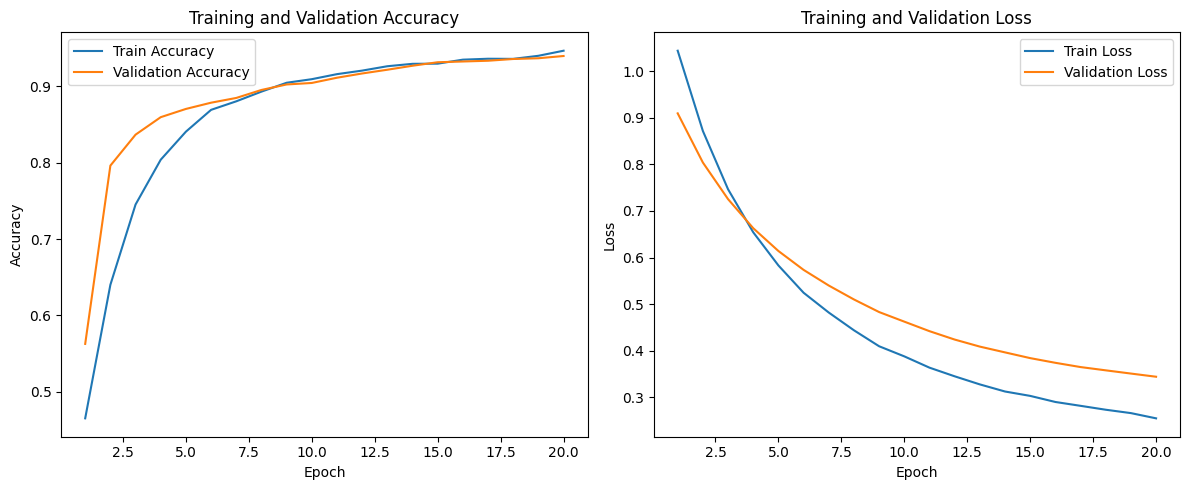

In [26]:
num_epochs = 20

# Step 2: Plot the metrics
plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
 
# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, num_epochs + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Model evaluation
best_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [28]:
print(classification_report(true_labels, predictions, target_names=test_dataset.classes))

              precision    recall  f1-score   support

        real       0.92      0.94      0.93      1020
      replay       0.95      0.97      0.96      1020
       print       0.97      0.93      0.95      1020

    accuracy                           0.95      3060
   macro avg       0.95      0.95      0.95      3060
weighted avg       0.95      0.95      0.95      3060



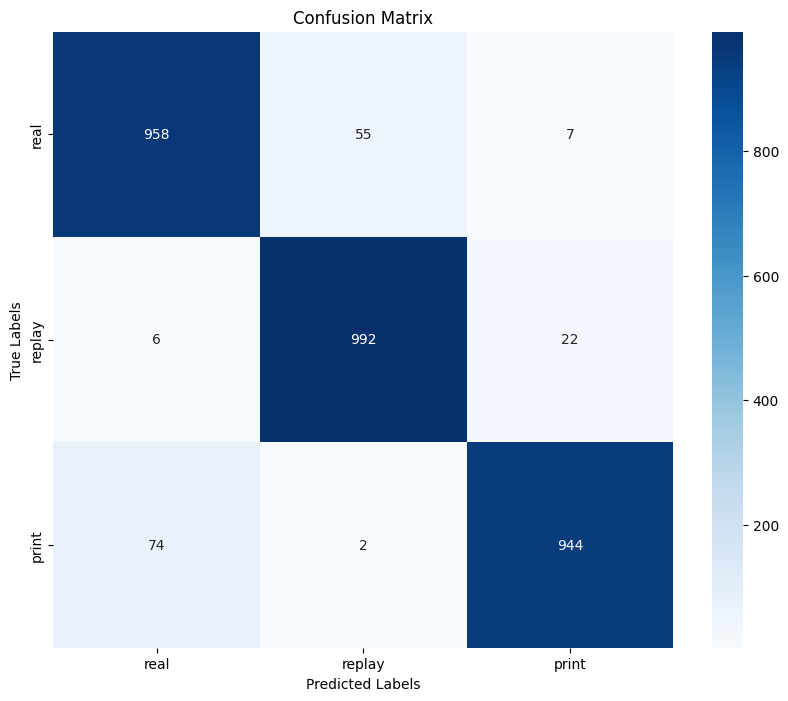

In [29]:
# Step 2: Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [30]:
# Save model
torch.save(best_model.state_dict(), f'{folder_save}/Swin-Transformer-Weight-CA-dict-doandl2-{current_date}.pth')
torch.save(best_model, f'{folder_save}/Swin-Transformer-Weight-CA-doandl2-{current_date}.pth')
torch.save(history, f'{folder_save}/Swin-Transformer-Weight-CA-history-doandl2-{current_date}.pth')

### Model Pretrained EfficientNet + Weights

In [31]:
torch.cuda.empty_cache()

In [23]:
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights, progress=True)
num_classes = 3

# Freeze the backbone
for param in model.features.parameters():
    param.requires_grad = False

# Get the number of input features from the original linear layer
in_features = model.classifier[1].in_features

# Replace the entire classifier with a new Sequential block
dropout_prob = 0.7
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_prob),
    nn.Linear(in_features, num_classes)
)

model = model.to(device)
summary(model, input_size=(1, 3, 224, 224))


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 3]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 24, 112, 112]         (648)
│    │    └─BatchNorm2d: 3-2                            [1, 24, 112, 112]         (48)
│    │    └─SiLU: 3-3                                   [1, 24, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 24, 112, 112]         --
│    │    └─FusedMBConv: 3-4                            [1, 24, 112, 112]         (5,232)
│    │    └─FusedMBConv: 3-5                            [1, 24, 112, 112]         (5,232)
│    └─Sequential: 2-3                                  [1, 48, 56, 56]           --
│    │    └─FusedMBConv: 3-6                 

In [24]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=0.00001,
    weight_decay=0.1
)

In [25]:
best_model, history = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,  
    num_epochs=20 
)

Epoch 1/20 => Train Loss: 1.0995 Acc: 0.3857 | Val Loss: 1.0040 Acc: 0.6392 | New best model saved!
Epoch 2/20 => Train Loss: 1.0052 Acc: 0.5115 | Val Loss: 0.9214 Acc: 0.7454 | New best model saved!
Epoch 3/20 => Train Loss: 0.9316 Acc: 0.6103 | Val Loss: 0.8541 Acc: 0.8075 | New best model saved!
Epoch 4/20 => Train Loss: 0.8654 Acc: 0.6754 | Val Loss: 0.7786 Acc: 0.8307 | New best model saved!
Epoch 5/20 => Train Loss: 0.8139 Acc: 0.7222 | Val Loss: 0.7523 Acc: 0.8284 | 
Epoch 6/20 => Train Loss: 0.7621 Acc: 0.7576 | Val Loss: 0.7084 Acc: 0.8366 | New best model saved!
Epoch 7/20 => Train Loss: 0.7275 Acc: 0.7792 | Val Loss: 0.6630 Acc: 0.8578 | New best model saved!
Epoch 8/20 => Train Loss: 0.6942 Acc: 0.7922 | Val Loss: 0.6335 Acc: 0.8657 | New best model saved!
Epoch 9/20 => Train Loss: 0.6591 Acc: 0.8103 | Val Loss: 0.6412 Acc: 0.8464 | 
Epoch 10/20 => Train Loss: 0.6361 Acc: 0.8199 | Val Loss: 0.5998 Acc: 0.8601 | 
Epoch 11/20 => Train Loss: 0.6117 Acc: 0.8254 | Val Loss: 0.58

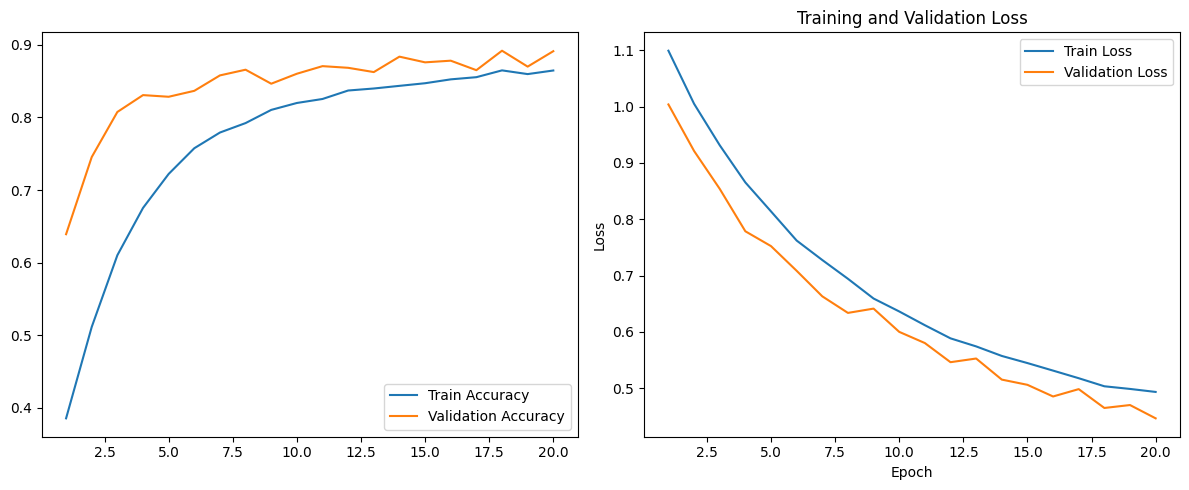

In [26]:
num_epochs = 20

# Step 2: Plot the metrics
plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), history["val_acc"], label="Validation Accuracy")
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, num_epochs + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Model evaluation
best_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [28]:
print(classification_report(true_labels, predictions, target_names=test_dataset.classes))

              precision    recall  f1-score   support

        real       0.94      0.96      0.95      1020
      replay       0.80      0.99      0.88      1020
       print       0.99      0.73      0.84      1020

    accuracy                           0.89      3060
   macro avg       0.91      0.89      0.89      3060
weighted avg       0.91      0.89      0.89      3060



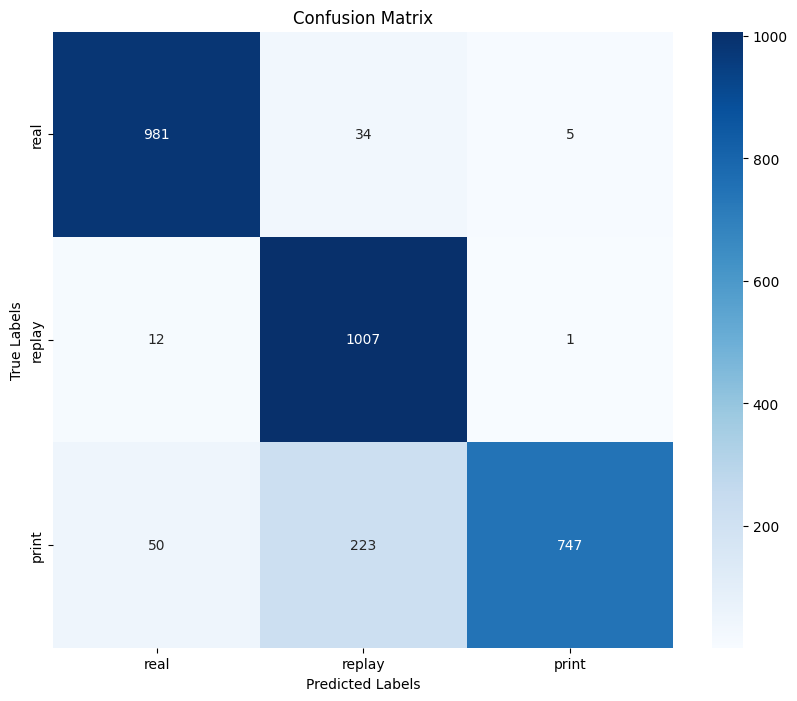

In [29]:
# Step 2: Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [30]:
# Save model
torch.save(best_model.state_dict(), f'{folder_save}/EfficientNetV2-Weights-CA-dict-doandl2-{current_date}.pth')
torch.save(best_model, f'{folder_save}/EfficientNetV2-Weights-CA-doandl2-{current_date}.pth')
torch.save(best_model, f'{folder_save}/EfficientNetV2-Weights-CA-history-doandl2-{current_date}.pth')

- Swin Name Files: "Swin-Transformer-Weight-CA-dict-doandl2-07-01-16"
- EffiecientNet: "EfficientNetV2-Weights-CA-dict-doandl2-07-01-18"

### Wrapper

In [31]:
torch.cuda.empty_cache()

In [23]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_STATE = 42
NUM_CLASSES = 3
N_SPLITS = 5  
BATCH_SIZE = 32

In [24]:
class PyTorchModelWrapper(BaseEstimator, ClassifierMixin):
    """
    Sebuah wrapper untuk membuat model PyTorch kompatibel dengan API Scikit-learn,
    terutama untuk digunakan dalam pipeline seperti StackingClassifier.
    """
    def __init__(self, model_fn, optimizer_cls, criterion, num_epochs=10, batch_size=32, lr=1e-3, weights=0.01):
        self.model_fn = model_fn
        self.optimizer_cls = optimizer_cls
        self.criterion = criterion
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.lr = lr
        self.weights = weights
        self.model_ = None
        self.classes_ = np.arange(NUM_CLASSES) # Diperlukan oleh Scikit-learn

    def fit(self, X, y):
        # Scikit-learn akan memberikan X (DataFrame) dan y (label)
        self.model_ = self.model_fn().to(DEVICE)
        optimizer = self.optimizer_cls(filter(lambda p: p.requires_grad, self.model_.parameters()), lr=self.lr, weight_decay=self.weights)
        
        # --- Menjembatani Scikit-learn ke PyTorch ---
        fit_df = X.copy()
        fit_df['label_encoded'] = y
        
        original_dataset = VideoFrameDataset(dataframe=fit_df, transform=transform_ori_train, class_names=class_names)
        augmented_dataset = VideoFrameDataset(dataframe=fit_df, transform=transform_train, class_names=class_names)
        train_dataset = ConcatDataset([original_dataset, augmented_dataset])
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        print(f"  Melatih {self.model_.__class__.__name__} pada {len(X)} sampel selama {self.num_epochs} epoch")
        
        # Loop training PyTorch standar
        for epoch in range(self.num_epochs):
            self.model_.train()
            for inputs, labels in train_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                optimizer.zero_grad()
                outputs = self.model_(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        return self

    def predict_proba(self, X):
        self.model_.eval()
        all_probs = []

        # --- Jembatan untuk inferensi ---
        predict_df = X.copy()
        if 'label_encoded' not in predict_df.columns:
            predict_df['label_encoded'] = 0 # Kolom dummy jika diperlukan

        val_dataset = VideoFrameDataset(predict_df, transform=transform_val_test, class_names=class_names)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        
        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.to(DEVICE)
                outputs = self.model_(inputs)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                all_probs.append(probs.cpu().numpy())
            
        return np.concatenate(all_probs)

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

In [25]:
def get_swin_model():
    # 1. Muat model dengan bobot pre-trained
    weights = Swin_T_Weights.DEFAULT
    model = swin_t(weights=weights)

    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Ganti head classifier untuk tugas kita
    dropout_prob = 0.5
    in_features = model.head.in_features
    model.head = nn.Sequential(
        nn.Dropout(p=dropout_prob),
        nn.Linear(in_features, NUM_CLASSES)
    )
    return model


def get_efficientnet_model():
    # 1. Muat model dengan bobot pre-trained
    weights = EfficientNet_V2_S_Weights.DEFAULT
    model = efficientnet_v2_s(weights=weights)

    # # 2. Bekukan backbone
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Ganti head classifier
    dropout_prob = 0.7
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_prob),  
        nn.Linear(in_features, NUM_CLASSES)
    )
    return model


### Build Ensemble Stacking

In [26]:
base_estimator_swin = PyTorchModelWrapper(
    model_fn=get_swin_model,
    optimizer_cls=optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    num_epochs=5, # Jumlah epoch untuk melatih setiap fold
    lr=0.00001,
    weights=0.1
)

base_estimator_effnet = PyTorchModelWrapper(
    model_fn=get_efficientnet_model,
    optimizer_cls=optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    num_epochs=5,
    lr=0.00001,
    weights=0.1
)

# 2. Definisikan meta-learner (final estimator)
meta_learner = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=NUM_CLASSES,
    eval_metric='mlogloss',
    eta=0.1,
    max_depth=6,
    random_state=RANDOM_STATE
)

# 3. Buat daftar estimator dasar
estimators = [
    ('swin_transformer', base_estimator_swin),
    ('efficientnet_v2', base_estimator_effnet)
]

# 4. Definisikan strategi cross-validation
cv_strategy = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# 5. Buat Stacking Classifier
# Scikit-learn akan menangani semua proses K-Fold secara otomatis di belakang layar
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=cv_strategy,
    stack_method='predict_proba',
    n_jobs=1, 
    verbose=2 
)

### Train

In [27]:
X_train = train_df.drop('label_encoded', axis=1)
y_train = train_df['label_encoded']
X_test = test_df.drop('label_encoded', axis=1)
y_test = test_df['label_encoded']

# Latih keseluruhan ensemble
stacking_clf.fit(X_train, y_train)
print("Stacking Classifier berhasil dilatih.")

  Melatih SwinTransformer pada 9180 sampel selama 5 epoch
  Melatih EfficientNet pada 9180 sampel selama 5 epoch
  Melatih SwinTransformer pada 7344 sampel selama 5 epoch
  Melatih SwinTransformer pada 7344 sampel selama 5 epoch
  Melatih SwinTransformer pada 7344 sampel selama 5 epoch
  Melatih SwinTransformer pada 7344 sampel selama 5 epoch
  Melatih SwinTransformer pada 7344 sampel selama 5 epoch
  Melatih EfficientNet pada 7344 sampel selama 5 epoch
  Melatih EfficientNet pada 7344 sampel selama 5 epoch
  Melatih EfficientNet pada 7344 sampel selama 5 epoch
  Melatih EfficientNet pada 7344 sampel selama 5 epoch
  Melatih EfficientNet pada 7344 sampel selama 5 epoch
Stacking Classifier berhasil dilatih.


### Testing


Akurasi Akhir Ensemble Stacking pada Test Set: 0.9817

Laporan Klasifikasi:
              precision    recall  f1-score   support

        real       0.95      1.00      0.97      1020
      replay       1.00      0.96      0.98      1020
       print       1.00      0.99      0.99      1020

    accuracy                           0.98      3060
   macro avg       0.98      0.98      0.98      3060
weighted avg       0.98      0.98      0.98      3060



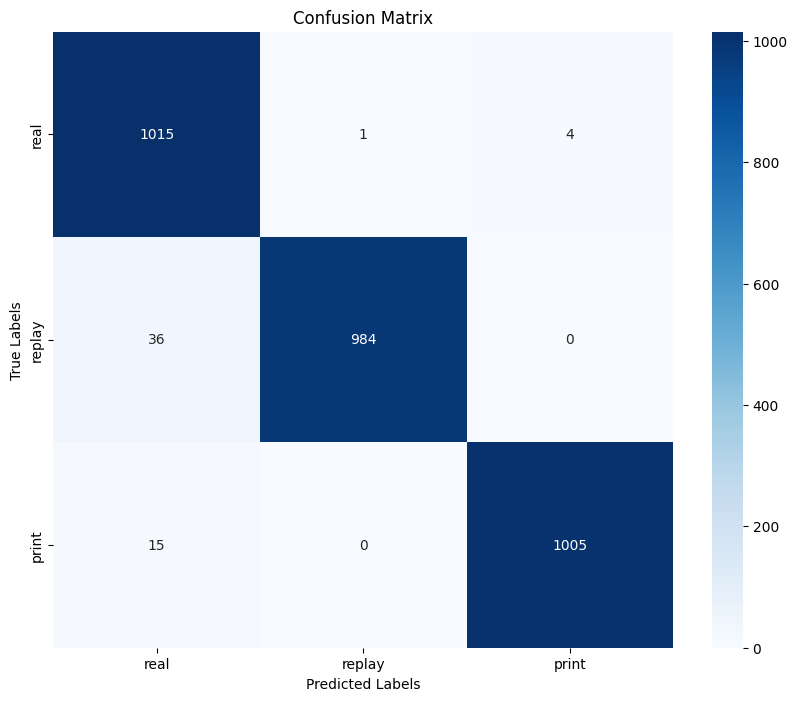

In [28]:
final_predictions = stacking_clf.predict(X_test)
final_accuracy = accuracy_score(y_test, final_predictions)

print(f"\nAkurasi Akhir Ensemble Stacking pada Test Set: {final_accuracy:.4f}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, final_predictions, target_names=class_names))

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_test, final_predictions)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### Saving Ensemble Model

In [29]:
try:
    trained_swin_model = stacking_clf.estimators_[0].model_
    torch.save(trained_swin_model.state_dict(), os.path.join(folder_save, f"swin_transformer_base-{current_date}.pth"))

    trained_effnet_model = stacking_clf.estimators_[1].model_
    torch.save(trained_effnet_model.state_dict(), os.path.join(folder_save, f"efficientnet_v2_base-{current_date}.pth"))
except Exception as e:
    print(f"Gagal menyimpan model dasar PyTorch. Pastikan 'stacking_clf' sudah dilatih. Error: {e}")


# 2. Menyimpan Meta-Learner (Final Estimator)
# Meta-learner yang sudah dilatih disimpan dalam atribut .final_estimator_
try:
    meta_learner_xgb = stacking_clf.final_estimator_
    meta_learner_xgb.save_model(os.path.join(folder_save, f"xgb_meta_learner-{current_date}.json"))
except Exception as e:
    print(f"Gagal menyimpan meta-learner XGBoost. Error: {e}")

### Pipeline to Use Ensemble Stacking

In [30]:
class LivenessEnsemblePipeline:
    def __init__(self, model_dir, device):
        self.device = device
        self.model_dir = model_dir
        self.class_names = ['real', 'replay', 'print'] # Pastikan urutan ini benar

        # Inisialisasi arsitektur dan muat bobot
        self.swin_model = self._load_swin_model()
        self.effnet_model = self._load_effnet_model()
        self.xgb_model = self._load_xgb_model()

        # Siapkan pipeline transformasi untuk gambar input
        self.transform = v2.Compose([
            v2.Resize((224, 224)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def _load_swin_model(self):
        try:
            model = swin_t(weights=None, num_classes=3)
            model.head = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(model.head.in_features, 3))
            model.load_state_dict(torch.load(os.path.join(self.model_dir, f"swin_transformer_base-{current_date}.pth"), map_location=self.device))
            model.to(self.device)
            model.eval()
            return model
        except FileNotFoundError:
            print(f"❌ ERROR: File bobot 'swin_transformer_base.pth' tidak ditemukan di '{self.model_dir}'")
            return None

    def _load_effnet_model(self):
        try:
            model = efficientnet_v2_s(weights=None, num_classes=3)
            in_features = model.classifier[1].in_features
            model.classifier = nn.Sequential(nn.Dropout(p=0.7), nn.Linear(in_features, 3))
            model.load_state_dict(torch.load(os.path.join(self.model_dir, f"efficientnet_v2_base-{current_date}.pth"), map_location=self.device))
            model.to(self.device)
            model.eval()
            return model
        except FileNotFoundError:
            print(f"❌ ERROR: File bobot 'efficientnet_v2_base.pth' tidak ditemukan di '{self.model_dir}'")
            return None

    def _load_xgb_model(self):
        try:
            model = xgb.XGBClassifier()
            model.load_model(os.path.join(self.model_dir, f"xgb_meta_learner-{current_date}.json"))
            return model
        except (xgb.core.XGBoostError, FileNotFoundError):
            print(f"❌ ERROR: File meta-learner 'xgb_meta_learner.json' tidak ditemukan di '{self.model_dir}'")
            return None

    def predict(self, image_path):
        """
        Membuat prediksi pada satu file gambar dan mengembalikan hasilnya dalam bentuk dictionary.
        """
        # Pastikan semua model berhasil dimuat
        if not all([self.swin_model, self.effnet_model, self.xgb_model]):
            print("Tidak bisa melakukan prediksi karena salah satu atau lebih model gagal dimuat.")
            return None
            
        try:
            image = Image.open(image_path).convert("RGB")
            input_tensor = self.transform(image).unsqueeze(0).to(self.device)

            with torch.no_grad():
                # Langkah 1: Dapatkan probabilitas dari model dasar
                swin_probs = torch.nn.functional.softmax(self.swin_model(input_tensor), dim=1)
                effnet_probs = torch.nn.functional.softmax(self.effnet_model(input_tensor), dim=1)
                
                # Langkah 2: Gabungkan probabilitas menjadi fitur untuk XGBoost
                meta_features = torch.cat((swin_probs, effnet_probs), dim=1).cpu().numpy()
                
                # Langkah 3: Dapatkan PROBABILITAS dari XGBoost, bukan hanya prediksi
                final_probabilities = self.xgb_model.predict_proba(meta_features)[0]
                
                # Langkah 4: Hitung hasil akhir
                predicted_idx = np.argmax(final_probabilities)
                confidence = final_probabilities[predicted_idx]
                predicted_class = self.class_names[predicted_idx]

                # Kembalikan hasil dalam format dictionary yang terstruktur
                return {
                    "predicted_class": predicted_class,
                    "confidence": float(confidence),
                    "all_probabilities": {name: float(prob) for name, prob in zip(self.class_names, final_probabilities)}
                }

        except FileNotFoundError:
            print(f"Error: File gambar tidak ditemukan di '{image_path}'")
            return None
        except Exception as e:
            print(f"Terjadi kesalahan saat prediksi: {e}")
            return None

    def display_prediction_results(self, prediction_result):
        """Menampilkan hasil prediksi yang terstruktur dari metode .predict()"""
        if prediction_result is None:
            return

        print(f"\n--- Hasil Prediksi Ensemble ---")
        print(f"Kelas Terprediksi: {prediction_result['predicted_class']}")
        print(f"Tingkat Kepercayaan: {prediction_result['confidence']:.4f}")
        print("Probabilitas untuk semua kelas:")
        for class_name, prob in prediction_result['all_probabilities'].items():
            print(f"  - {class_name}: {prob:.4f}")

## Test Model

### Pipeline to Use Base Model

In [31]:
def load_inference_model(model_type, model_path, num_classes, device):
    """
    Memuat, membangun, dan menyiapkan model untuk inferensi.
    Fungsi ini dapat digunakan kembali untuk model yang berbeda.

    Args:
        model_type (str): Tipe model, 'swin' atau 'efficientnet'.
        model_path (str): Path ke file bobot model (.pth).
        num_classes (int): Jumlah kelas output.
        device: Device PyTorch (CPU atau CUDA).

    Returns:
        model: Model PyTorch yang sudah dilatih dan siap untuk evaluasi.
    """
    print(f"\n--- Memuat model tipe: {model_type} ---")
    
    # Inisialisasi model berdasarkan tipenya
    if model_type.lower() == 'swin':
        model = swin_t(weights=None, num_classes=num_classes)
        # Rekonstruksi head yang sama persis seperti saat training
        in_features = model.head.in_features
        model.head = nn.Sequential(
            nn.Dropout(p=0.5), 
            nn.Linear(in_features, num_classes)
        )
    elif model_type.lower() == 'efficientnetv2':
        model = efficientnet_v2_s(weights=None, num_classes=num_classes)
        # Rekonstruksi classifier yang sama persis seperti saat training
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.7), # Ganti dropout jika berbeda saat training
            nn.Linear(in_features, num_classes)
        )
    else:
        raise ValueError("Tipe model tidak dikenal. Gunakan 'swin' atau 'efficientnet'.")

    # Muat bobot yang sudah dilatih
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Bobot berhasil dimuat dari: {model_path}")
    except FileNotFoundError:
        print(f"ERROR: File bobot tidak ditemukan di {model_path}")
        return None
    except RuntimeError as e:
        print(f"ERROR: Struktur model tidak cocok dengan file bobot. Pastikan arsitektur sama. Detail: {e}")
        return None
        
    # Siapkan model untuk inferensi
    model.to(device)
    model.eval()
    
    return model

def load_and_preprocess_image(image_path):
    """Memuat gambar, melakukan preprocessing, dan mengembalikannya sebagai tensor."""
    transform = v2.Compose([
        v2.Resize((224, 224)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Error: File gambar tidak ditemukan di {image_path}")
        return None
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor

def predict(model, image_tensor, device):
    """Melakukan inferensi pada model dan mengembalikan prediksi."""
    if image_tensor is None or model is None:
        return None
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
    return output

def display_results(output, class_names):
    """Menampilkan hasil prediksi."""
    if output is None:
        return
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    confidence, predicted_idx = torch.max(probabilities, 0)
    predicted_class_name = class_names[predicted_idx.item()]

    print(f"\n--- Hasil Prediksi ---")
    print(f"Model: {model.__class__.__name__}")
    print(f"Kelas Terprediksi: {predicted_class_name} (index: {predicted_idx.item()})")
    print(f"Tingkat Kepercayaan: {confidence.item():.4f}")
    print("Probabilitas untuk semua kelas:")
    for i, prob in enumerate(probabilities):
        print(f"  - {class_names[i]}: {prob.item():.4f}")

### Test Model

In [32]:
MODELS = ['swin', 'efficientnetv2', 'ensemble']
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 3
CLASS_NAMES = ["real", "replay", "print"]
HOME_PATH = home_path
FOLDER_SAVE = folder_save
IMAGE_TO_TEST = f'{home_path}/tests/real_5.jpg'

for model_type in MODELS:
    if model_type == 'swin':
        MODEL_WEIGHTS_PATH = os.path.join(FOLDER_SAVE, f"swin_transformer_base-{current_date}.pth")
    elif model_type == 'efficientnetv2':
        MODEL_WEIGHTS_PATH = os.path.join(FOLDER_SAVE, f"efficientnet_v2_base-{current_date}.pth")
    elif model_type == 'ensemble':
        system = LivenessEnsemblePipeline(FOLDER_SAVE, DEVICE)
    
    if model_type != 'ensemble':
        model = load_inference_model(
            model_type=model_type,
            model_path=MODEL_WEIGHTS_PATH,
            num_classes=NUM_CLASSES,
            device=DEVICE
        )
        start = time.time()
        image_tensor = load_and_preprocess_image(IMAGE_TO_TEST)
        output = predict(model, image_tensor, DEVICE)
        display_results(output, CLASS_NAMES)
        end = time.time()
        print(f"Prediksi selesai dalam {end - start:.4f} detik.")
    else:
        start = time.time()
        result = system.predict(IMAGE_TO_TEST)
        system.display_prediction_results(result)
        end = time.time()
        print(f"Prediksi selesai dalam {end - start:.4f} detik.")



--- Memuat model tipe: swin ---
Bobot berhasil dimuat dari: /home/machi/code/python/TelU-TugasAkhir-LivenessDetection/results/GroupShuffle/swin_transformer_base-07-12-19.pth

--- Hasil Prediksi ---
Model: SwinTransformer
Kelas Terprediksi: real (index: 0)
Tingkat Kepercayaan: 0.5931
Probabilitas untuk semua kelas:
  - real: 0.5931
  - replay: 0.1141
  - print: 0.2928
Prediksi selesai dalam 0.0746 detik.

--- Memuat model tipe: efficientnetv2 ---
Bobot berhasil dimuat dari: /home/machi/code/python/TelU-TugasAkhir-LivenessDetection/results/GroupShuffle/efficientnet_v2_base-07-12-19.pth

--- Hasil Prediksi ---
Model: EfficientNet
Kelas Terprediksi: replay (index: 1)
Tingkat Kepercayaan: 0.3682
Probabilitas untuk semua kelas:
  - real: 0.3239
  - replay: 0.3682
  - print: 0.3079
Prediksi selesai dalam 0.0936 detik.

--- Hasil Prediksi Ensemble ---
Kelas Terprediksi: print
Tingkat Kepercayaan: 0.5037
Probabilitas untuk semua kelas:
  - real: 0.4945
  - replay: 0.0018
  - print: 0.5037
Pred

## Evaluation

In [33]:
swin_location = os.path.join(FOLDER_SAVE, f"Swin-Transformer-Weight-CA-dict-doandl2-{current_date}.pth")
effnet_location = os.path.join(FOLDER_SAVE, f"EfficientNetV2-Weights-CA-dict-doandl2-{current_date}.pth")
swin_model = load_inference_model(
    model_type='swin',
    model_path=swin_location,
    num_classes=NUM_CLASSES,
    device=DEVICE
)
effnet_model = load_inference_model(
    model_type='efficientnetv2',
    model_path=effnet_location,
    num_classes=NUM_CLASSES,
    device=DEVICE
)
full_ensemble_system = LivenessEnsemblePipeline(FOLDER_SAVE, DEVICE)
models = [swin_model, effnet_model, full_ensemble_system]



--- Memuat model tipe: swin ---
Bobot berhasil dimuat dari: /home/machi/code/python/TelU-TugasAkhir-LivenessDetection/results/GroupShuffle/Swin-Transformer-Weight-CA-dict-doandl2-07-12-19.pth

--- Memuat model tipe: efficientnetv2 ---
Bobot berhasil dimuat dari: /home/machi/code/python/TelU-TugasAkhir-LivenessDetection/results/GroupShuffle/EfficientNetV2-Weights-CA-dict-doandl2-07-12-19.pth


### FPR and Accuracy

In [34]:
def calculate_fpr(model, dataloader, class_names, device):
    """
    Mengevaluasi model pada dataloader, menghitung FPR untuk setiap kelas,
    dan menampilkan hasilnya. Fungsi ini menggabungkan proses prediksi dan kalkulasi.
    
    Args:
        model: Model PyTorch yang sudah dilatih dan siap dievaluasi.
        dataloader (DataLoader): DataLoader untuk data tes.
        class_names (list): Daftar nama kelas sesuai urutan label (misal: ['real', 'replay', 'print']).
        device: Device PyTorch (CPU atau CUDA).
        
    Returns:
        dict: Sebuah dictionary yang berisi nilai FPR untuk setiap kelas.
    """    
    # --- Bagian 1: Mendapatkan Semua Prediksi dari Dataloader ---
    # Kode ini diambil dari potongan yang Anda berikan.
    model.to(device)
    model.eval()
    all_predictions = []
    all_true_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            
            # Dapatkan output dari model Anda
            outputs = model(images) 
            _, preds = torch.max(outputs, 1)
            
            all_predictions.extend(preds.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    
    # --- Bagian 2: Menghitung FPR dari Confusion Matrix ---
    # Logika ini sekarang ada di dalam fungsi yang sama.
    cm = confusion_matrix(all_true_labels, all_predictions)
    fpr_per_class = {}
    
    for i, class_name in enumerate(class_names):
        # i adalah indeks kelas positif kita saat ini
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        
        # Hitung FPR sesuai rumus di proposal Anda
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        fpr_per_class[class_name] = fpr
        
    # --- Bagian 3: Menampilkan Semua Hasil ---
    print("\n--- Laporan Klasifikasi Lengkap ---")
    print(classification_report(all_true_labels, all_predictions, target_names=class_names))
        
    print(f"FPR untuk model {model.__class__.__name__}:")
    for class_name, fpr in fpr_per_class.items():
        print(f"  - {class_name}: {fpr:.4f}")

def calculate_ensemble_fpr(ensemble_pipeline, dataloader):
    """
    Mengevaluasi keseluruhan pipeline ensemble pada test set, menampilkan laporan
    lengkap, dan menghitung FPR untuk setiap kelas.
    """    
    # Ambil komponen-komponen yang diperlukan dari pipeline
    swin_model = ensemble_pipeline.swin_model
    effnet_model = ensemble_pipeline.effnet_model
    xgb_model = ensemble_pipeline.xgb_model
    device = ensemble_pipeline.device
    class_names = ensemble_pipeline.class_names
    
    all_final_preds = []
    all_true_labels = []
    
    # Proses ini tidak memerlukan gradien
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            
            # Jalankan keseluruhan pipeline inferensi
            swin_probs = torch.nn.functional.softmax(swin_model(images), dim=1)
            effnet_probs = torch.nn.functional.softmax(effnet_model(images), dim=1)
            meta_features = torch.cat((swin_probs, effnet_probs), dim=1).cpu().numpy()
            final_preds = xgb_model.predict(meta_features)
            
            all_final_preds.extend(final_preds)
            all_true_labels.extend(labels.cpu().numpy())
    
    print("Prediksi ensemble selesai. Menghitung metrik...")
    
    # Hitung FPR dari confusion matrix
    cm = confusion_matrix(all_true_labels, all_final_preds)
    fpr_per_class = {}
    
    for i, class_name in enumerate(class_names):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        fpr_per_class[class_name] = fpr
        
    # Tampilkan semua hasil
    print("\n--- Laporan Klasifikasi Lengkap untuk Ensemble ---")
    print(classification_report(all_true_labels, all_final_preds, target_names=class_names))
    
    print("\n--- Hasil False Positive Rate (FPR) untuk Ensemble ---")
    for class_name, fpr in fpr_per_class.items():
        print(f"FPR untuk kelas '{class_name}': {fpr:.4f}")

### Test Inference Time

In [35]:
for model in models:
    if model is not full_ensemble_system:
        print(f"\nMenghitung FPR untuk model {model.__class__.__name__}")
        calculate_fpr(model, test_dataloader, test_dataset.classes, DEVICE)
    else:
        print(f"\nMenghitung FPR untuk model {model.__class__.__name__} Model Ensemble")
        calculate_ensemble_fpr(model, test_dataloader)
    print("\n============================")


Menghitung FPR untuk model SwinTransformer

--- Laporan Klasifikasi Lengkap ---
              precision    recall  f1-score   support

        real       0.92      0.94      0.93      1020
      replay       0.95      0.97      0.96      1020
       print       0.97      0.93      0.95      1020

    accuracy                           0.95      3060
   macro avg       0.95      0.95      0.95      3060
weighted avg       0.95      0.95      0.95      3060

FPR untuk model SwinTransformer:
  - real: 0.0392
  - replay: 0.0279
  - print: 0.0142


Menghitung FPR untuk model EfficientNet

--- Laporan Klasifikasi Lengkap ---
              precision    recall  f1-score   support

        real       0.94      0.96      0.95      1020
      replay       0.80      0.99      0.88      1020
       print       0.99      0.73      0.84      1020

    accuracy                           0.89      3060
   macro avg       0.91      0.89      0.89      3060
weighted avg       0.91      0.89      0.89   

In [36]:
def calculate_iso_metrics(y_true, y_pred, class_names):
    """Menghitung metrik APCER dan BPCER dari confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    try:
        real_idx = class_names.index('real')
        attack_indices = [i for i, name in enumerate(class_names) if name != 'real']
    except ValueError:
        return {"APCER": -1, "BPCER": -1}

    # BPCER
    total_real = cm[real_idx, :].sum()
    fn_real = total_real - cm[real_idx, real_idx]
    bpcer = fn_real / total_real if total_real > 0 else 0.0

    # APCER
    total_attack = cm[attack_indices, :].sum()
    fp_real = cm[attack_indices, real_idx].sum()
    apcer = fp_real / total_attack if total_attack > 0 else 0.0

    # APCER (replay)
    total_replay_attacks = cm[class_names.index('replay'), :].sum()
    replay_misclassified_as_real = cm[class_names.index('replay'), real_idx]
    apcer_replay = replay_misclassified_as_real / total_replay_attacks if total_replay_attacks > 0 else 0.0

    # APCER untuk serangan Print
    total_print_attacks = cm[class_names.index('print'), :].sum()
    print_misclassified_as_real = cm[class_names.index('print'), real_idx]
    apcer_print = print_misclassified_as_real / total_print_attacks if total_print_attacks > 0 else 0.0

    
    return {
        "APCER": apcer,
        "BPCER": bpcer,
        "APCER_replay": apcer_replay,
        "APCER_print": apcer_print,
    }

def evaluate_model_and_get_iso_metrics(model, dataloader, class_names, device):
    """Fungsi all-in-one untuk mengevaluasi model TUNGGAL."""
    print(f"--- Evaluasi Model : {model.__class__.__name__} ---")
    model.to(device)
    model.eval()
    all_predictions = []
    all_true_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images) 
            _, preds = torch.max(outputs, 1)
            all_predictions.extend(preds.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
    
    # Menampilkan Laporan Klasifikasi
    print("Accuracy: {:.4f}".format(accuracy_score(all_true_labels, all_predictions)))
    # print(classification_report(all_true_labels, all_predictions, target_names=class_names))
    
    # Menghitung dan Menampilkan Metrik ISO
    iso_metrics = calculate_iso_metrics(all_true_labels, all_predictions, class_names)
    print(f"BPCER: {iso_metrics['BPCER']:.4f}")
    print(f"APCER: {iso_metrics['APCER']:.4f}")
    print(f"APCER (Replay): {iso_metrics['APCER_replay']:.4f}")
    print(f"APCER (Print): {iso_metrics['APCER_print']:.4f}")
    print(f"ACER  : {(iso_metrics['BPCER'] + iso_metrics['APCER']) / 2:.4f}")
    
    return iso_metrics

def evaluate_ensemble_model_and_get_iso_metrics(ensemble_pipeline, dataloader):
    """
    Fungsi all-in-one untuk mengevaluasi keseluruhan pipeline ENSEMBLE.
    Fungsi ini melakukan prediksi, menampilkan laporan lengkap, dan menghitung metrik APCER/BPCER.
    
    Args:
        ensemble_pipeline (LivenessEnsemblePipeline): Objek ensemble Anda yang sudah dimuat.
        dataloader (DataLoader): DataLoader untuk data tes.
        
    Returns:
        dict: Sebuah dictionary yang berisi nilai APCER dan BPCER.
    """
    print(f"\n--- Evaluasi Model : Ensemble ---")
    
    # --- BAGIAN 1: PROSES INFERENSI ENSEMBLE ---
    
    # Ambil komponen-komponen yang diperlukan dari pipeline
    swin_model = ensemble_pipeline.swin_model
    effnet_model = ensemble_pipeline.effnet_model
    xgb_model = ensemble_pipeline.xgb_model
    device = ensemble_pipeline.device
    class_names = ensemble_pipeline.class_names
    
    all_final_preds = []
    all_true_labels = []
    
    # Pastikan tidak ada gradien yang dilacak untuk efisiensi
    with torch.no_grad():
        # Iterasi melalui seluruh test dataloader
        for images, labels in dataloader:
            images = images.to(device)
            
            # Langkah A: Dapatkan probabilitas dari model dasar
            swin_probs = torch.nn.functional.softmax(swin_model(images), dim=1)
            effnet_probs = torch.nn.functional.softmax(effnet_model(images), dim=1)
            
            # Langkah B: Gabungkan probabilitas menjadi fitur untuk XGBoost
            meta_features = torch.cat((swin_probs, effnet_probs), dim=1).cpu().numpy()
            
            # Langkah C: Dapatkan prediksi akhir dari XGBoost
            final_preds = xgb_model.predict(meta_features)
            
            # Kumpulkan hasil prediksi dan label asli
            all_final_preds.extend(final_preds)
            all_true_labels.extend(labels.cpu().numpy())
            

    # --- BAGIAN 2: ANALISIS HASIL ---
    
    # a. Menampilkan Laporan Klasifikasi
    print("Accuracy: {:.4f}".format(accuracy_score(all_true_labels, all_final_preds)))
    # print(classification_report(all_true_labels, all_final_preds, target_names=class_names))

    # b. Menghitung dan Menampilkan Metrik ISO (APCER/BPCER)
    iso_metrics = calculate_iso_metrics(all_true_labels, all_final_preds, class_names)
    print(f"BPCER : {iso_metrics['BPCER']:.4f}")
    print(f"APCER : {iso_metrics['APCER']:.4f}")
    print(f"APCER (Replay): {iso_metrics['APCER_replay']:.4f}")
    print(f"APCER (Print): {iso_metrics['APCER_print']:.4f}")
    print(f"ACER  : {(iso_metrics['BPCER'] + iso_metrics['APCER']) / 2:.4f}")
    
    return iso_metrics

In [37]:
for model in models:
    if model is not full_ensemble_system:
        evaluate_model_and_get_iso_metrics(model, test_dataloader, test_dataset.classes, DEVICE)
    else:
        evaluate_ensemble_model_and_get_iso_metrics(model, test_dataloader)
    print("\n============================")

--- Evaluasi Model : SwinTransformer ---
Accuracy: 0.9458
BPCER: 0.0608
APCER: 0.0392
APCER (Replay): 0.0059
APCER (Print): 0.0725
ACER  : 0.0500

--- Evaluasi Model : EfficientNet ---
Accuracy: 0.8938
BPCER: 0.0382
APCER: 0.0304
APCER (Replay): 0.0118
APCER (Print): 0.0490
ACER  : 0.0343


--- Evaluasi Model : Ensemble ---
Accuracy: 0.9817
BPCER : 0.0049
APCER : 0.0250
APCER (Replay): 0.0353
APCER (Print): 0.0147
ACER  : 0.0150

